<h3>导入包</h3>

In [285]:
import os
import logging
from datetime import datetime
from typing import Optional, Union
from chinese_calendar import is_workday, is_holiday, is_in_lieu, get_holiday_detail
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import zipfile
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas import DataFrame, Series, Timestamp, Timedelta, DatetimeIndex
import matplotlib.pyplot as plt
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from sklearn.metrics import r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.base import RegressorMixin
from sklearn.metrics import r2_score
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, TimeDistributed, Dense, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, History
from tensorflow.keras.backend import clear_session
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.optimizers import Adam


tf.random.set_seed(42)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
tf.compat.v1.reset_default_graph()
clear_session()


warnings.filterwarnings('ignore')
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', level=logging.INFO)

<h3>读入数据</h3>

<h4>读入A榜数据</h4>

In [286]:
sub_sheet_name = ["二层插座", "二层照明", "一层插座", "一层照明", "空调"]
data_dict = {}
for name in sub_sheet_name:
    data_dict[name] = pd.read_csv('../data/Data_A/' + name + '_EC.csv')
    data_dict[name]["time"] = pd.to_datetime(data_dict[name]["time"])

<h4>读入B榜数据</h4>

In [287]:
for name in sub_sheet_name:
    data_b = pd.read_csv('../data/Data_B/' + name + '_EC_B.csv')
    data_b["time"] = pd.to_datetime(data_b["time"])
    data_dict[name] = pd.concat([data_dict[name], data_b], axis=0)
data_dict

{'二层插座':                    time     value
 0   2013-08-03 00:00:00  0.164062
 1   2013-08-03 00:15:00  0.121094
 2   2013-08-03 00:30:00  0.101562
 3   2013-08-03 00:45:00  0.087891
 4   2013-08-03 01:00:00  0.103516
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.093750
 668 2015-08-10 23:00:00  0.089844
 669 2015-08-10 23:15:00  0.093750
 670 2015-08-10 23:30:00  0.097656
 671 2015-08-10 23:45:00  0.074219
 
 [64072 rows x 2 columns], '二层照明':                    time     value
 0   2013-08-03 00:00:00  0.500000
 1   2013-08-03 00:15:00  0.507812
 2   2013-08-03 00:30:00  0.476562
 3   2013-08-03 00:45:00  0.117188
 4   2013-08-03 01:00:00  0.000000
 ..                  ...       ...
 667 2015-08-10 22:45:00  0.062500
 668 2015-08-10 23:00:00  0.078125
 669 2015-08-10 23:15:00  0.062500
 670 2015-08-10 23:30:00  0.109375
 671 2015-08-10 23:45:00  0.273438
 
 [64320 rows x 2 columns], '一层插座':                    time     value
 0   2013-08-03 00:00:00  0.113281
 1   2013-

<h3>读入天气数据</h3>

In [288]:
wh = pd.read_csv("../data/Data_A/天气.csv")
wh["日期"] = pd.to_datetime(wh["日期"])
wh["time"] = wh["日期"] + pd.to_timedelta(wh["小时"], "h")
wh.drop(["Unnamed: 0", "日期", "小时"], axis=1, inplace=True)
wh = wh.set_index("time", drop=True)
wh

,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,
2013-08-03 00:00:00,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,25,75,0.4,1007,东北风,35,7,2


<h3>合并数据</h3>

<h4>对齐数据</h4>

In [289]:
data = pd.merge(data_dict["二层插座"],data_dict["二层照明"],on='time', how="inner", suffixes=("_socket_2","_light_2"))
data = pd.merge(data,data_dict["一层插座"],on='time', how="inner", suffixes=("","_socket_1"))
data = pd.merge(data,data_dict["一层照明"],on='time', how="inner", suffixes=("","_light_1"))
data = pd.merge(data,data_dict["空调"],on='time', how="inner", suffixes=("","_air"))
data = data.rename(columns={"value":"value_socket_1"})
data

,time,value_socket_2,value_light_2,value_socket_1,value_light_1,value_air
0,2013-08-03 00:00:00,0.164062,0.500000,0.113281,0.542969,4.234375
1,2013-08-03 00:15:00,0.121094,0.507812,0.273438,0.542969,5.093750
2,2013-08-03 00:30:00,0.101562,0.476562,0.277344,0.515625,3.234375
3,2013-08-03 00:45:00,0.087891,0.117188,0.218750,0.437500,3.187500
4,2013-08-03 01:00:00,0.103516,0.000000,0.082031,0.406250,3.171875
...,...,...,...,...,...,...
63832,2015-08-10 22:45:00,0.093750,0.062500,0.125000,0.234375,1.750000
63833,2015-08-10 23:00:00,0.089844,0.078125,0.117188,0.218750,1.781250
63834,2015-08-10 23:15:00,0.093750,0.062500,0.132812,0.218750,1.718750
63835,2015-08-10 23:30:00,0.097656,0.109375,0.179688,0.203125,2.937500


<h4>将一二层数据相加</h4>

<AxesSubplot:>

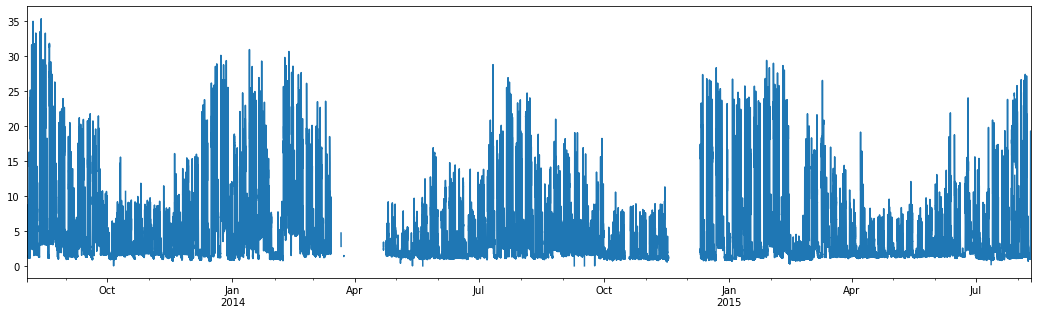

In [290]:
data["value_socket"] = data["value_socket_2"] + data["value_socket_1"]
data["value_light"] = data["value_light_2"] + data["value_light_1"]
data.drop(['value_socket_2','value_light_2','value_socket_1','value_light_1'], axis=1, inplace=True)
data["value_total"] = data.sum(axis=1)
data = data.set_index("time", drop=True)
data = data.reindex(pd.date_range(start=data.index[0], end=data.index[-1], freq="15T"))
data["value_total"].plot(figsize=(18,5))

<h3>处理缺失值</h3>

<h4>查看大段的nan</h4>

In [291]:
data.loc['2014-03-14 13:00:00' : '2014-04-23 20:15:00']

,value_air,value_socket,value_light,value_total
2014-03-14 13:00:00,2.43750,1.539062,1.710938,5.687500
2014-03-14 13:15:00,2.37500,1.769531,1.777344,5.921875
2014-03-14 13:30:00,2.37500,1.347656,1.882812,5.605469
2014-03-14 13:45:00,NaN,NaN,NaN,NaN
2014-03-14 14:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-04-23 19:15:00,NaN,NaN,NaN,NaN
2014-04-23 19:30:00,NaN,NaN,NaN,NaN
2014-04-23 19:45:00,NaN,NaN,NaN,NaN
2014-04-23 20:00:00,NaN,NaN,NaN,NaN


In [292]:
data.loc['2014-11-17 08:00:00' : '2014-12-10 17:15:00']

,value_air,value_socket,value_light,value_total
2014-11-17 08:00:00,0.59375,0.390625,0.320312,1.304688
2014-11-17 08:15:00,0.59375,0.207031,0.281250,1.082031
2014-11-17 08:30:00,NaN,NaN,NaN,NaN
2014-11-17 08:45:00,NaN,NaN,NaN,NaN
2014-11-17 09:00:00,NaN,NaN,NaN,NaN
...,...,...,...,...
2014-12-10 16:15:00,NaN,NaN,NaN,NaN
2014-12-10 16:30:00,NaN,NaN,NaN,NaN
2014-12-10 16:45:00,11.62500,1.718750,2.039062,15.382812
2014-12-10 17:00:00,12.15625,1.757812,2.039062,15.953125


<h4>查看所有缺失值的index，并将该小时的Timestamp记录下来</h4>

In [293]:
nan_index = data[data["value_total"].isnull()].index
nan_index_hours = []
for idx in nan_index:
    nan_index_hour = Timestamp(year=idx.year, month=idx.month, day=idx.day, hour=idx.hour)
    nan_index_hours.append(nan_index_hour)
nan_index_hours.extend(pd.date_range("2014-03-14 13:00:00", "2014-04-23 20:00:00", freq="1H").tolist())
nan_index_hours.extend(pd.date_range("2014-11-17 08:00:00", "2014-12-10 16:00:00", freq="1H").tolist())
nan_index_hours = np.unique(nan_index_hours)
DatetimeIndex(nan_index_hours)

DatetimeIndex(['2013-08-04 12:00:00', '2013-08-07 07:00:00',
               '2013-10-14 10:00:00', '2013-10-14 11:00:00',
               '2013-10-14 12:00:00', '2013-10-14 13:00:00',
               '2013-10-14 14:00:00', '2013-10-14 15:00:00',
               '2013-10-14 16:00:00', '2013-10-14 17:00:00',
               ...
               '2015-07-30 08:00:00', '2015-07-30 09:00:00',
               '2015-07-30 11:00:00', '2015-07-30 12:00:00',
               '2015-07-30 14:00:00', '2015-07-30 15:00:00',
               '2015-07-30 17:00:00', '2015-07-30 18:00:00',
               '2015-07-30 20:00:00', '2015-07-30 21:00:00'],
              dtype='datetime64[ns]', length=1860, freq=None)

<h4>对少数缺失值进行插值补全</h4>

In [294]:
data["value_air"] = data["value_air"].interpolate(method="time")
data["value_light"] = data["value_light"].interpolate(method="time")
data["value_socket"] = data["value_socket"].interpolate(method="time")
data["value_total"] = data["value_total"].interpolate(method="time")

<h3>按照每小时相加</h3>

In [295]:
data = data.resample("1H").sum()
data.loc["2014-03-14 13:00:00" : "2014-04-23 20:00:00", :] = np.nan
data.loc["2014-11-17 08:00:00" : "2014-12-10 16:00:00", :] = np.nan
data = data.dropna()
data

,value_air,value_socket,value_light,value_total
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484
...,...,...,...,...
2015-08-10 19:00:00,8.500000,1.277344,3.750000,13.527344
2015-08-10 20:00:00,3.531250,1.292969,2.382812,7.207031
2015-08-10 21:00:00,3.312500,1.203125,1.117188,5.632812
2015-08-10 22:00:00,5.000000,1.035156,1.234375,7.269531


<h3>合并天气数据</h3>

In [296]:
data = pd.merge(data, wh, how="right", left_index=True, right_index=True)
data

,value_air,value_socket,value_light,value_total,温度(C°),湿度(%),降雨量(mm),大气压(hPa),风向,风向角度(°),风速(KM/H),云量(%)
time,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28,88,1.0,1006,东南风,159,9,71
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28,88,0.9,1006,东南风,155,8,75
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28,89,0.7,1006,东南风,150,8,54
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27,90,0.5,1006,东南风,151,8,25
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27,90,0.2,1006,东南风,151,8,35
...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,27,67,0.0,1006,东北风,43,11,1
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,26,72,0.0,1007,东北风,45,9,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,25,75,0.4,1007,东北风,35,7,2


<h3>TODO 特征工程</h3>

<h4>修改列名</h4>

In [297]:
data = data.rename(columns={
    "温度(C°)":"temp",
    "湿度(%)":"humidity",
    "降雨量(mm)":"rainfall",
    "大气压(hPa)":"atmos",
    "风向":"wind_direction",
    "风向角度(°)":"wind_angle",
    "风速(KM/H)":"wind_speed",
    "云量(%)":"cloud"
})

<h4>自定义特征工程</h4>

In [298]:
data['workday'] = list(map(lambda x: int(is_workday(x)), data.index.to_list()))
data['hour'] = list(map(lambda x: x.hour, data.index.to_list()))
data['week'] = list(map(lambda x: x.weekday(), data.index.to_list()))
data['day'] = list(map(lambda x: x.day, data.index.to_list()))
data['month'] = list(map(lambda x: x.month, data.index.to_list()))
data['year'] = list(map(lambda x: x.year, data.index.to_list()))
data["temp"] = data["temp"].rolling("12H").mean()
data["is_summer"] = data["month"].apply(lambda x: x in (6, 7, 8)).astype(int)
data["is_winter"] = data["month"].apply(lambda x: x in (12, 1, 2)).astype(int)
# data = pd.concat([data.loc[: "2015-08-03 23:00:00"].dropna(), data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00"]], axis=0)
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_direction,wind_angle,wind_speed,cloud,workday,hour,week,day,month,year,is_summer,is_winter
time,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,东南风,159,9,71,0,0,5,3,8,2013,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,东南风,155,8,75,0,1,5,3,8,2013,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,东南风,150,8,54,0,2,5,3,8,2013,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,东南风,151,8,25,0,3,5,3,8,2013,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,东南风,151,8,35,0,4,5,3,8,2013,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,东北风,43,11,1,1,19,0,24,8,2015,1,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,东北风,45,9,0,1,20,0,24,8,2015,1,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,东北风,35,7,2,1,21,0,24,8,2015,1,0


<h3>对类别特征onehot</h3>

<h4>对风向进行onehot</h4>

In [299]:
onehot_wind = OneHotEncoder(sparse=False)
onehot_wind.fit(data[["wind_direction"]])
data = pd.concat([data, DataFrame(onehot_wind.transform(data[["wind_direction"]]), columns=onehot_wind.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["wind_direction"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,is_summer,is_winter,东北风,东南风,东风,北风,南风,西北风,西南风,西风
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,1,0,1,0,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,1,0,1,0,0,0,0,0,0,0


<h4>对星期几进行onehot</h4>

In [300]:
data["week"] = data["week"].apply(lambda x: "星期" + str(x + 1))
onehot_week = OneHotEncoder(sparse=False)
onehot_week.fit(data[["week"]])
data = pd.concat([data, DataFrame(onehot_week.transform(data[["week"]]), columns=onehot_week.categories_[0], index=data.index).astype(int)], axis=1)
data = data.drop(columns=["week"])
data

,value_air,value_socket,value_light,value_total,temp,humidity,rainfall,atmos,wind_angle,wind_speed,...,西北风,西南风,西风,星期1,星期2,星期3,星期4,星期5,星期6,星期7
time,,,,,,,,,,,,,,,,,,,,,
2013-08-03 00:00:00,15.750000,1.357422,3.640625,20.748047,28.000000,88,1.0,1006,159,9,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 01:00:00,12.390625,0.785156,1.621094,14.796875,28.000000,88,0.9,1006,155,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 02:00:00,10.953125,0.771484,1.632812,13.357422,28.000000,89,0.7,1006,150,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 03:00:00,11.343750,0.830078,1.613281,13.787109,27.750000,90,0.5,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
2013-08-03 04:00:00,12.671875,1.162109,1.812500,15.646484,27.600000,90,0.2,1006,151,8,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-08-24 19:00:00,NaN,NaN,NaN,NaN,28.500000,67,0.0,1006,43,11,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 20:00:00,NaN,NaN,NaN,NaN,28.583333,72,0.0,1007,45,9,...,0,0,0,1,0,0,0,0,0,0
2015-08-24 21:00:00,NaN,NaN,NaN,NaN,28.500000,75,0.4,1007,35,7,...,0,0,0,1,0,0,0,0,0,0


<h3>构建模型</h3>

In [301]:
def r2_metric(y_pred, y_true):
    result1 = r2_score(y_true[0:24], y_pred[0:24])
    result2 = r2_score(y_true[24:48], y_pred[24:48])
    result3 = r2_score(y_true[48:72], y_pred[48:72])
    result4 = r2_score(y_true[72:96], y_pred[72:96])
    result5 = r2_score(y_true[96:120], y_pred[96:120])
    result6 = r2_score(y_true[120:144], y_pred[120:144])
    result7 = r2_score(y_true[144:168], y_pred[144:168])
    return "r2 score", 0.25 * result1 + 0.15 * (result2 + result3 + result4) + 0.1 * (result5 + result6 + result7), True

In [302]:
def cross_validation(estimator: RegressorMixin, n_splits: int, x_train_val: DataFrame, y_train_val: Series, x_test: DataFrame) -> np.ndarray:
    """
    交叉验证\n
    """
    models = []
    scores = []
    oof_preds = np.zeros((x_train_val.shape[0],))
    test_preds = np.zeros((x_test.shape[0],))
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for fold, (train_index, val_index) in enumerate(kfold.split(x_train_val, y_train_val)):
        x_train, x_val, y_train, y_val = x_train_val.iloc[train_index], x_train_val.iloc[val_index], y_train_val[train_index], y_train_val[val_index]

        estimator = estimator.fit(x_train, y_train, eval_set=(x_val, y_val), eval_metric=r2_metric, early_stopping_rounds=20)
        models.append(estimator)

        oof_preds[val_index] = estimator.predict(x_val, num_iteration=estimator.best_iteration_)
        test_preds += estimator.predict(x_test, num_iteration=estimator.best_iteration_) / kfold.n_splits
        score = r2_metric(y_val, estimator.predict(x_val, num_iteration=estimator.best_iteration_))[1]
        
        logging.info(f'############ fold: {fold}, r2: {score} ###########')
        scores.append(score)
    logging.info(f'############ cross validation r2 score: {np.mean(scores)} ###########')
    return test_preds

In [303]:
def shift_column(ser: Series, num: int) -> DataFrame:
    """
    取历史值\n
    """
    result = DataFrame()
    for i in range(1, num + 1):
        result["%s-%d" % (ser.name, i)] = ser.shift(i)
    return result

In [304]:
def clip_maxmin(ser: Series, _clip_min_: bool, _clip_max_: bool) -> Series:
    """
    把最小值最大值变为次小值次大值\n
    """
    result = ser.copy()
    if _clip_min_:
        idx = result.argmin()
        result[result == result.min()] = np.nan
        result.iloc[idx] = result.min()
    if _clip_max_:
        idx = result.argmax()
        result[result == result.max()] == np.nan
        result.iloc[idx] = result.max()
    return result

In [305]:
def clip_value(ser: Union[Series, np.ndarray], _min_val_: Optional[float] = None, _max_val_: Optional[float] = None) -> Series:
    """
    把小于最小值的替换成最小值\n
    """
    result = ser.copy()
    if _min_val_:
        result[result < _min_val_] = _min_val_
    if _max_val_:
        result[result > _max_val_] = _max_val_
    return result

In [306]:
@tf.function
def split_xy(x):
    return x[:, :, 1:], x[:, :, 0]

<h4>针对socket构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

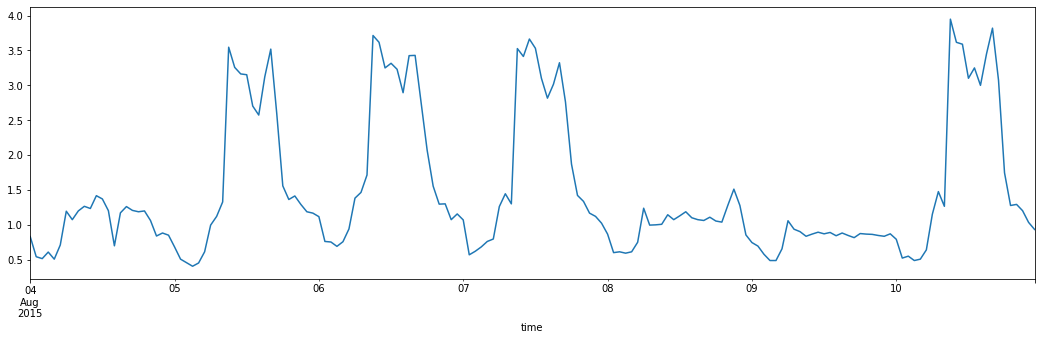

In [307]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_socket"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [308]:
data_socket = data.drop(columns=["value_light", "value_air", "value_total"])
x_train_socket = data_socket.drop(columns=["value_socket"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_socket = data_socket["value_socket"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_socket = data_socket.drop(columns=["value_socket"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_socket.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [309]:
model_socket1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred1 = model_socket1.predict(x_test_socket)

<h5>取最后7*24个点作为模型2预测值</h5>

In [310]:
socket_pred2 = data_socket.loc[: "2015-08-10 23:00:00", "value_socket"].values[-7*24:]

<h5>构建catboost</h5>

In [311]:
model_socket3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_socket, y_train_socket, sample_weight=sample_weight)
socket_pred3 = model_socket3.predict(x_test_socket)

Learning rate set to 0.063357
0:	learn: 1.9149907	total: 2.87ms	remaining: 2.86s
1:	learn: 1.8253912	total: 5.08ms	remaining: 2.53s
2:	learn: 1.7437267	total: 7.39ms	remaining: 2.45s
3:	learn: 1.6675864	total: 9.6ms	remaining: 2.39s
4:	learn: 1.5970328	total: 11.8ms	remaining: 2.35s
5:	learn: 1.5322906	total: 13.9ms	remaining: 2.31s
6:	learn: 1.4725279	total: 16ms	remaining: 2.27s
7:	learn: 1.4175430	total: 18.1ms	remaining: 2.24s
8:	learn: 1.3677487	total: 20.2ms	remaining: 2.23s
9:	learn: 1.3214854	total: 22.3ms	remaining: 2.21s
10:	learn: 1.2797198	total: 24.5ms	remaining: 2.21s
11:	learn: 1.2416612	total: 26.7ms	remaining: 2.19s
12:	learn: 1.2066908	total: 28.7ms	remaining: 2.18s
13:	learn: 1.1751173	total: 30.9ms	remaining: 2.17s
14:	learn: 1.1459798	total: 32.9ms	remaining: 2.16s
15:	learn: 1.1186943	total: 35ms	remaining: 2.15s
16:	learn: 1.0940975	total: 37ms	remaining: 2.14s
17:	learn: 1.0722933	total: 39.2ms	remaining: 2.14s
18:	learn: 1.0524600	total: 41.2ms	remaining: 2.13s

184:	learn: 0.6157445	total: 359ms	remaining: 1.58s
185:	learn: 0.6151795	total: 360ms	remaining: 1.58s
186:	learn: 0.6138535	total: 362ms	remaining: 1.57s
187:	learn: 0.6133926	total: 364ms	remaining: 1.57s
188:	learn: 0.6128579	total: 366ms	remaining: 1.57s
189:	learn: 0.6120054	total: 368ms	remaining: 1.57s
190:	learn: 0.6112177	total: 370ms	remaining: 1.56s
191:	learn: 0.6108485	total: 371ms	remaining: 1.56s
192:	learn: 0.6102167	total: 374ms	remaining: 1.56s
193:	learn: 0.6093252	total: 376ms	remaining: 1.56s
194:	learn: 0.6087532	total: 378ms	remaining: 1.56s
195:	learn: 0.6081643	total: 380ms	remaining: 1.56s
196:	learn: 0.6074983	total: 382ms	remaining: 1.56s
197:	learn: 0.6067345	total: 384ms	remaining: 1.55s
198:	learn: 0.6062571	total: 386ms	remaining: 1.55s
199:	learn: 0.6054310	total: 388ms	remaining: 1.55s
200:	learn: 0.6047970	total: 390ms	remaining: 1.55s
201:	learn: 0.6040431	total: 392ms	remaining: 1.55s
202:	learn: 0.6034237	total: 393ms	remaining: 1.54s
203:	learn: 

377:	learn: 0.5291168	total: 719ms	remaining: 1.18s
378:	learn: 0.5288624	total: 721ms	remaining: 1.18s
379:	learn: 0.5286019	total: 723ms	remaining: 1.18s
380:	learn: 0.5284358	total: 725ms	remaining: 1.18s
381:	learn: 0.5282586	total: 727ms	remaining: 1.18s
382:	learn: 0.5280932	total: 728ms	remaining: 1.17s
383:	learn: 0.5278081	total: 730ms	remaining: 1.17s
384:	learn: 0.5275581	total: 732ms	remaining: 1.17s
385:	learn: 0.5272171	total: 734ms	remaining: 1.17s
386:	learn: 0.5269405	total: 736ms	remaining: 1.17s
387:	learn: 0.5265377	total: 738ms	remaining: 1.16s
388:	learn: 0.5261375	total: 740ms	remaining: 1.16s
389:	learn: 0.5258590	total: 742ms	remaining: 1.16s
390:	learn: 0.5256302	total: 744ms	remaining: 1.16s
391:	learn: 0.5253976	total: 745ms	remaining: 1.16s
392:	learn: 0.5248447	total: 747ms	remaining: 1.15s
393:	learn: 0.5245245	total: 749ms	remaining: 1.15s
394:	learn: 0.5241311	total: 751ms	remaining: 1.15s
395:	learn: 0.5240373	total: 753ms	remaining: 1.15s
396:	learn: 

574:	learn: 0.4812752	total: 1.08s	remaining: 799ms
575:	learn: 0.4809147	total: 1.08s	remaining: 797ms
576:	learn: 0.4807483	total: 1.08s	remaining: 795ms
577:	learn: 0.4803824	total: 1.09s	remaining: 793ms
578:	learn: 0.4803028	total: 1.09s	remaining: 791ms
579:	learn: 0.4801320	total: 1.09s	remaining: 789ms
580:	learn: 0.4799764	total: 1.09s	remaining: 787ms
581:	learn: 0.4797373	total: 1.09s	remaining: 785ms
582:	learn: 0.4794865	total: 1.09s	remaining: 784ms
583:	learn: 0.4793853	total: 1.1s	remaining: 782ms
584:	learn: 0.4792272	total: 1.1s	remaining: 780ms
585:	learn: 0.4791199	total: 1.1s	remaining: 778ms
586:	learn: 0.4789210	total: 1.1s	remaining: 776ms
587:	learn: 0.4787717	total: 1.1s	remaining: 774ms
588:	learn: 0.4784575	total: 1.11s	remaining: 772ms
589:	learn: 0.4783215	total: 1.11s	remaining: 770ms
590:	learn: 0.4781125	total: 1.11s	remaining: 768ms
591:	learn: 0.4780116	total: 1.11s	remaining: 767ms
592:	learn: 0.4779384	total: 1.11s	remaining: 765ms
593:	learn: 0.477

772:	learn: 0.4490511	total: 1.44s	remaining: 423ms
773:	learn: 0.4488676	total: 1.44s	remaining: 422ms
774:	learn: 0.4487119	total: 1.45s	remaining: 420ms
775:	learn: 0.4484272	total: 1.45s	remaining: 418ms
776:	learn: 0.4482022	total: 1.45s	remaining: 416ms
777:	learn: 0.4480785	total: 1.45s	remaining: 414ms
778:	learn: 0.4478366	total: 1.45s	remaining: 412ms
779:	learn: 0.4476313	total: 1.46s	remaining: 410ms
780:	learn: 0.4475292	total: 1.46s	remaining: 409ms
781:	learn: 0.4473722	total: 1.46s	remaining: 407ms
782:	learn: 0.4471956	total: 1.46s	remaining: 405ms
783:	learn: 0.4470556	total: 1.46s	remaining: 403ms
784:	learn: 0.4469433	total: 1.46s	remaining: 401ms
785:	learn: 0.4467999	total: 1.47s	remaining: 399ms
786:	learn: 0.4466073	total: 1.47s	remaining: 397ms
787:	learn: 0.4464601	total: 1.47s	remaining: 395ms
788:	learn: 0.4463532	total: 1.47s	remaining: 394ms
789:	learn: 0.4462344	total: 1.47s	remaining: 392ms
790:	learn: 0.4461194	total: 1.48s	remaining: 390ms
791:	learn: 

969:	learn: 0.4233613	total: 1.8s	remaining: 55.8ms
970:	learn: 0.4232428	total: 1.8s	remaining: 53.9ms
971:	learn: 0.4230485	total: 1.81s	remaining: 52ms
972:	learn: 0.4229886	total: 1.81s	remaining: 50.2ms
973:	learn: 0.4228751	total: 1.81s	remaining: 48.3ms
974:	learn: 0.4227775	total: 1.81s	remaining: 46.5ms
975:	learn: 0.4226888	total: 1.81s	remaining: 44.6ms
976:	learn: 0.4225537	total: 1.81s	remaining: 42.7ms
977:	learn: 0.4224581	total: 1.82s	remaining: 40.9ms
978:	learn: 0.4222940	total: 1.82s	remaining: 39ms
979:	learn: 0.4222191	total: 1.82s	remaining: 37.2ms
980:	learn: 0.4220914	total: 1.82s	remaining: 35.3ms
981:	learn: 0.4220255	total: 1.82s	remaining: 33.5ms
982:	learn: 0.4219722	total: 1.83s	remaining: 31.6ms
983:	learn: 0.4218809	total: 1.83s	remaining: 29.7ms
984:	learn: 0.4217866	total: 1.83s	remaining: 27.9ms
985:	learn: 0.4216790	total: 1.83s	remaining: 26ms
986:	learn: 0.4215625	total: 1.83s	remaining: 24.2ms
987:	learn: 0.4214254	total: 1.84s	remaining: 22.3ms
9

<h5>构建xgboost</h5>

In [312]:
model_socket4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_socket, y_train_socket)
socket_pred4 = model_socket4.predict(x_test_socket)

<h5>构建深度模型</h5>

In [313]:
ds_socket1 = timeseries_dataset_from_array(
    data=data_socket.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket2 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket3 = timeseries_dataset_from_array(
    data=data_socket.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_socket = ds_socket1.concatenate(ds_socket2).concatenate(ds_socket3).map(split_xy)
ds_socket

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 44ms/step - loss: 6.8918 - mae: 1.8661
Epoch 2/100
124/124 [==============================] - 5s 39ms/step - loss: 1.7074 - mae: 0.8434
Epoch 3/100
124/124 [==============================] - 5s 39ms/step - loss: 1.2832 - mae: 0.7337
Epoch 4/100
124/124 [==============================] - 5s 39ms/step - loss: 1.1933 - mae: 0.7098
Epoch 5/100
124/124 [==============================] - 5s 39ms/step - loss: 1.0583 - mae: 0.6703
Epoch 6/100
124/124 [==============================] - 5s 39ms/step - loss: 0.9767 - mae: 0.6438
Epoch 7/100
124/124 [==============================] - 5s 39ms/step - loss: 0.9561 - mae: 0.6377
Epoch 8/100
124/124 [==============================] - 5s 39ms/step - loss: 0.8781 - mae: 0.6115
Epoch 9/100
124/124 [==============================] - 5s 39ms/step - loss: 0.7987 - mae: 0.5834
Epoch 10/100
124/124 [==============================] - 5s 39ms/step - loss: 0.7253 - mae: 0.5555
Epoch 11/100
124/124 [=======

124/124 [==============================] - 5s 41ms/step - loss: 0.0731 - mae: 0.1740
Epoch 85/100
124/124 [==============================] - 5s 42ms/step - loss: 0.0654 - mae: 0.1643
Epoch 86/100
124/124 [==============================] - 5s 42ms/step - loss: 0.0651 - mae: 0.1649
Epoch 87/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0646 - mae: 0.1638
Epoch 88/100
124/124 [==============================] - 5s 42ms/step - loss: 0.0626 - mae: 0.1609
Epoch 89/100
124/124 [==============================] - 5s 42ms/step - loss: 0.0648 - mae: 0.1631
Epoch 90/100
124/124 [==============================] - 5s 40ms/step - loss: 0.0642 - mae: 0.1627
Epoch 91/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0620 - mae: 0.1588
Epoch 92/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0612 - mae: 0.1584
Epoch 93/100
124/124 [==============================] - 5s 41ms/step - loss: 0.0615 - mae: 0.1586
Epoch 94/100
124/124 [===========

2023-04-13 10:35:07,536 [INFO] saving LSTM model to ../models/LSTM_socket.h5


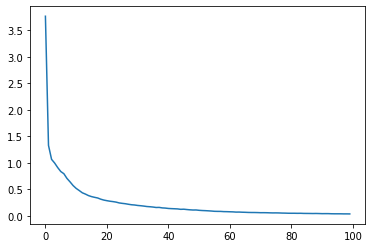

In [314]:
model_socket5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_socket.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_socket5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_socket5.load_weights("../models/LSTM_socket.h5")
    logging.info("loading LSTM model from ../models/LSTM_socket.h5")
except (OSError, ValueError) as e:
    history: History = model_socket5.fit(
        ds_socket,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_socket5.save_weights("../models/LSTM_socket.h5")
    logging.info("saving LSTM model to ../models/LSTM_socket.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [315]:
socket_pred5 = model_socket5.predict(np.expand_dims(x_test_socket.values, 0))[0, :, 0]

2023-04-13 10:35:08,240 [WARNING] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x0000022775ED92F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

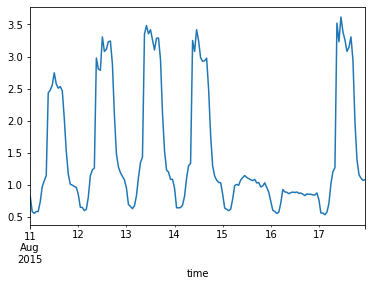

In [316]:
socket_pred = (socket_pred1 + socket_pred2 + socket_pred3 + socket_pred4 + socket_pred5) / 5
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"] = socket_pred
data_socket.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_socket"].plot()

<h4>针对light构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

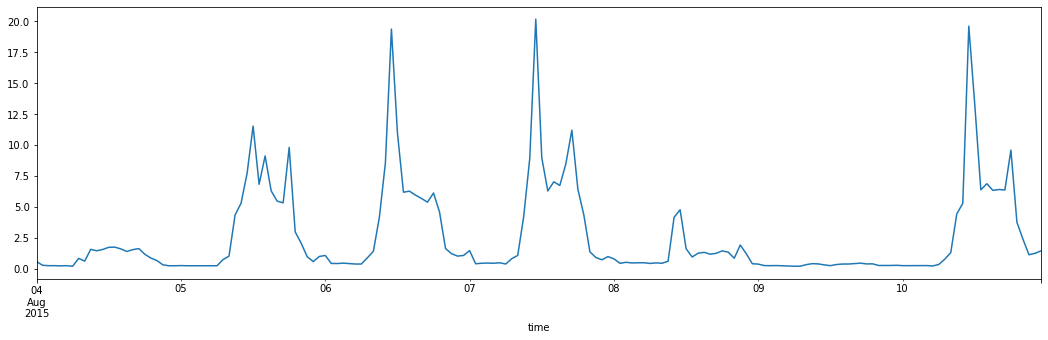

In [317]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_light"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [318]:
data_light = data.drop(columns=["value_socket", "value_air", "value_total", 'temp', 'humidity', 'atmos', 'wind_angle', 'wind_speed'])
x_train_light = data_light.drop(columns=["value_light"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_light = data_light["value_light"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_light = data_light.drop(columns=["value_light"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_light.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [319]:
model_light1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred1 = model_light1.predict(x_test_light)

<h5>取最后7*24个点作为模型2预测值</h5>

In [320]:
light_pred2 = data_light.loc[: "2015-08-10 23:00:00", "value_light"].values[-7*24:]

<h5>构建catboost</h5>

In [321]:
model_light3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_light, y_train_light, sample_weight=sample_weight)
light_pred3 = model_light3.predict(x_test_light)

Learning rate set to 0.063357
0:	learn: 3.5451917	total: 2.9ms	remaining: 2.9s
1:	learn: 3.3801371	total: 5.59ms	remaining: 2.79s
2:	learn: 3.2283088	total: 8.13ms	remaining: 2.7s
3:	learn: 3.0888932	total: 10.5ms	remaining: 2.62s
4:	learn: 2.9611128	total: 13.1ms	remaining: 2.61s
5:	learn: 2.8443397	total: 15.6ms	remaining: 2.58s
6:	learn: 2.7349265	total: 18.2ms	remaining: 2.58s
7:	learn: 2.6375220	total: 20.8ms	remaining: 2.58s
8:	learn: 2.5464359	total: 23.3ms	remaining: 2.56s
9:	learn: 2.4623687	total: 25.7ms	remaining: 2.55s
10:	learn: 2.3860334	total: 28.2ms	remaining: 2.54s
11:	learn: 2.3181796	total: 30.6ms	remaining: 2.52s
12:	learn: 2.2546163	total: 33ms	remaining: 2.5s
13:	learn: 2.1930518	total: 35.5ms	remaining: 2.5s
14:	learn: 2.1361466	total: 38ms	remaining: 2.49s
15:	learn: 2.0911800	total: 40.3ms	remaining: 2.48s
16:	learn: 2.0421376	total: 42.8ms	remaining: 2.47s
17:	learn: 2.0003294	total: 45.3ms	remaining: 2.47s
18:	learn: 1.9622773	total: 47.8ms	remaining: 2.47s
1

160:	learn: 1.3484683	total: 355ms	remaining: 1.85s
161:	learn: 1.3470328	total: 357ms	remaining: 1.84s
162:	learn: 1.3466577	total: 359ms	remaining: 1.84s
163:	learn: 1.3457206	total: 361ms	remaining: 1.84s
164:	learn: 1.3446871	total: 363ms	remaining: 1.84s
165:	learn: 1.3439148	total: 365ms	remaining: 1.83s
166:	learn: 1.3427315	total: 367ms	remaining: 1.83s
167:	learn: 1.3423708	total: 369ms	remaining: 1.83s
168:	learn: 1.3411275	total: 372ms	remaining: 1.83s
169:	learn: 1.3398995	total: 374ms	remaining: 1.82s
170:	learn: 1.3389167	total: 376ms	remaining: 1.82s
171:	learn: 1.3382388	total: 378ms	remaining: 1.82s
172:	learn: 1.3370533	total: 380ms	remaining: 1.82s
173:	learn: 1.3363851	total: 382ms	remaining: 1.81s
174:	learn: 1.3355044	total: 385ms	remaining: 1.81s
175:	learn: 1.3349512	total: 387ms	remaining: 1.81s
176:	learn: 1.3340035	total: 389ms	remaining: 1.81s
177:	learn: 1.3332249	total: 391ms	remaining: 1.8s
178:	learn: 1.3326093	total: 393ms	remaining: 1.8s
179:	learn: 1.

329:	learn: 1.2209089	total: 714ms	remaining: 1.45s
330:	learn: 1.2204699	total: 716ms	remaining: 1.45s
331:	learn: 1.2201519	total: 718ms	remaining: 1.45s
332:	learn: 1.2198715	total: 720ms	remaining: 1.44s
333:	learn: 1.2194004	total: 723ms	remaining: 1.44s
334:	learn: 1.2187211	total: 725ms	remaining: 1.44s
335:	learn: 1.2183175	total: 727ms	remaining: 1.44s
336:	learn: 1.2178899	total: 729ms	remaining: 1.43s
337:	learn: 1.2172406	total: 731ms	remaining: 1.43s
338:	learn: 1.2166570	total: 733ms	remaining: 1.43s
339:	learn: 1.2160545	total: 736ms	remaining: 1.43s
340:	learn: 1.2152818	total: 738ms	remaining: 1.43s
341:	learn: 1.2148688	total: 740ms	remaining: 1.42s
342:	learn: 1.2143189	total: 742ms	remaining: 1.42s
343:	learn: 1.2139362	total: 744ms	remaining: 1.42s
344:	learn: 1.2136174	total: 746ms	remaining: 1.42s
345:	learn: 1.2134260	total: 748ms	remaining: 1.41s
346:	learn: 1.2126880	total: 751ms	remaining: 1.41s
347:	learn: 1.2123567	total: 753ms	remaining: 1.41s
348:	learn: 

498:	learn: 1.1439583	total: 1.07s	remaining: 1.08s
499:	learn: 1.1435678	total: 1.07s	remaining: 1.07s
500:	learn: 1.1432861	total: 1.08s	remaining: 1.07s
501:	learn: 1.1426711	total: 1.08s	remaining: 1.07s
502:	learn: 1.1422800	total: 1.08s	remaining: 1.07s
503:	learn: 1.1419421	total: 1.08s	remaining: 1.07s
504:	learn: 1.1406724	total: 1.09s	remaining: 1.06s
505:	learn: 1.1404310	total: 1.09s	remaining: 1.06s
506:	learn: 1.1402574	total: 1.09s	remaining: 1.06s
507:	learn: 1.1397513	total: 1.09s	remaining: 1.06s
508:	learn: 1.1392974	total: 1.09s	remaining: 1.06s
509:	learn: 1.1386584	total: 1.1s	remaining: 1.05s
510:	learn: 1.1382621	total: 1.1s	remaining: 1.05s
511:	learn: 1.1378263	total: 1.1s	remaining: 1.05s
512:	learn: 1.1372996	total: 1.1s	remaining: 1.05s
513:	learn: 1.1370311	total: 1.11s	remaining: 1.05s
514:	learn: 1.1368435	total: 1.11s	remaining: 1.04s
515:	learn: 1.1362209	total: 1.11s	remaining: 1.04s
516:	learn: 1.1359893	total: 1.11s	remaining: 1.04s
517:	learn: 1.13

666:	learn: 1.0835918	total: 1.43s	remaining: 716ms
667:	learn: 1.0833201	total: 1.44s	remaining: 713ms
668:	learn: 1.0829882	total: 1.44s	remaining: 711ms
669:	learn: 1.0825392	total: 1.44s	remaining: 709ms
670:	learn: 1.0823449	total: 1.44s	remaining: 707ms
671:	learn: 1.0817923	total: 1.44s	remaining: 705ms
672:	learn: 1.0813559	total: 1.45s	remaining: 703ms
673:	learn: 1.0811241	total: 1.45s	remaining: 701ms
674:	learn: 1.0807439	total: 1.45s	remaining: 699ms
675:	learn: 1.0799810	total: 1.45s	remaining: 696ms
676:	learn: 1.0794981	total: 1.46s	remaining: 694ms
677:	learn: 1.0788270	total: 1.46s	remaining: 692ms
678:	learn: 1.0785820	total: 1.46s	remaining: 690ms
679:	learn: 1.0781529	total: 1.46s	remaining: 688ms
680:	learn: 1.0777632	total: 1.46s	remaining: 686ms
681:	learn: 1.0776333	total: 1.47s	remaining: 683ms
682:	learn: 1.0773955	total: 1.47s	remaining: 681ms
683:	learn: 1.0771781	total: 1.47s	remaining: 679ms
684:	learn: 1.0768234	total: 1.47s	remaining: 677ms
685:	learn: 

835:	learn: 1.0315665	total: 1.79s	remaining: 352ms
836:	learn: 1.0309870	total: 1.79s	remaining: 349ms
837:	learn: 1.0308100	total: 1.8s	remaining: 347ms
838:	learn: 1.0305699	total: 1.8s	remaining: 345ms
839:	learn: 1.0304850	total: 1.8s	remaining: 343ms
840:	learn: 1.0302257	total: 1.8s	remaining: 341ms
841:	learn: 1.0300808	total: 1.8s	remaining: 339ms
842:	learn: 1.0298789	total: 1.81s	remaining: 337ms
843:	learn: 1.0295676	total: 1.81s	remaining: 335ms
844:	learn: 1.0294057	total: 1.81s	remaining: 332ms
845:	learn: 1.0289296	total: 1.81s	remaining: 330ms
846:	learn: 1.0287479	total: 1.82s	remaining: 328ms
847:	learn: 1.0285950	total: 1.82s	remaining: 326ms
848:	learn: 1.0284305	total: 1.82s	remaining: 324ms
849:	learn: 1.0282097	total: 1.82s	remaining: 322ms
850:	learn: 1.0276164	total: 1.82s	remaining: 319ms
851:	learn: 1.0273870	total: 1.83s	remaining: 317ms
852:	learn: 1.0269378	total: 1.83s	remaining: 315ms
853:	learn: 1.0268108	total: 1.83s	remaining: 313ms
854:	learn: 1.026

<h5>构建xgboost</h5>

In [322]:
model_light4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_light, y_train_light)
light_pred4 = model_light4.predict(x_test_light)

<h5>构建深度模型</h5>

In [323]:
ds_light1 = timeseries_dataset_from_array(
    data=data_light.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light2 = timeseries_dataset_from_array(
    data=data_light.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light3 = timeseries_dataset_from_array(
    data=data_light.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_light = ds_light1.concatenate(ds_light2).concatenate(ds_light3).map(split_xy)
ds_light

<MapDataset shapes: ((None, None, 24), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 9s 44ms/step - loss: 22.4658 - mae: 3.3690
Epoch 2/100
124/124 [==============================] - 5s 38ms/step - loss: 7.1719 - mae: 1.6864
Epoch 3/100
124/124 [==============================] - 5s 38ms/step - loss: 5.5457 - mae: 1.4879
Epoch 4/100
124/124 [==============================] - 5s 39ms/step - loss: 4.8962 - mae: 1.3978
Epoch 5/100
124/124 [==============================] - 5s 39ms/step - loss: 4.3163 - mae: 1.3165
Epoch 6/100
124/124 [==============================] - 5s 39ms/step - loss: 3.9176 - mae: 1.2621
Epoch 7/100
124/124 [==============================] - 5s 39ms/step - loss: 3.5903 - mae: 1.2119
Epoch 8/100
124/124 [==============================] - 5s 39ms/step - loss: 3.3563 - mae: 1.1728
Epoch 9/100
124/124 [==============================] - 5s 39ms/step - loss: 3.1898 - mae: 1.1419
Epoch 10/100
124/124 [==============================] - 5s 41ms/step - loss: 3.0299 - mae: 1.1134
Epoch 11/100
124/124 [======

124/124 [==============================] - 5s 41ms/step - loss: 0.3431 - mae: 0.3505
Epoch 85/100
124/124 [==============================] - 5s 41ms/step - loss: 0.3233 - mae: 0.3362
Epoch 86/100
124/124 [==============================] - 5s 40ms/step - loss: 0.3182 - mae: 0.3353
Epoch 87/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3160 - mae: 0.3329
Epoch 88/100
124/124 [==============================] - 5s 40ms/step - loss: 0.3057 - mae: 0.3267
Epoch 89/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3146 - mae: 0.3291
Epoch 90/100
124/124 [==============================] - 5s 39ms/step - loss: 0.3150 - mae: 0.3302
Epoch 91/100
124/124 [==============================] - 5s 39ms/step - loss: 0.2920 - mae: 0.3174
Epoch 92/100
124/124 [==============================] - 5s 40ms/step - loss: 0.3004 - mae: 0.3213
Epoch 93/100
124/124 [==============================] - 5s 40ms/step - loss: 0.2972 - mae: 0.3213
Epoch 94/100
124/124 [===========

2023-04-13 10:43:33,529 [INFO] saving LSTM model to ../models/LSTM_light.h5


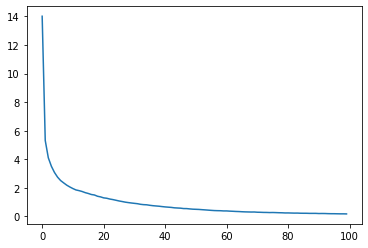

In [324]:
model_light5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_light.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_light5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_light5.load_weights("../models/LSTM_light.h5")
    logging.info("loading LSTM model from ../models/LSTM_light.h5")
except (OSError, ValueError) as e:
    history: History = model_light5.fit(
        ds_light,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_light.h5")
    logging.info("saving LSTM model to ../models/LSTM_light.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [325]:
light_pred5 = model_light5.predict(np.expand_dims(x_test_light.values, 0))[0, :, 0]

2023-04-13 10:43:34,246 [WARNING] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002277E2CBC80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

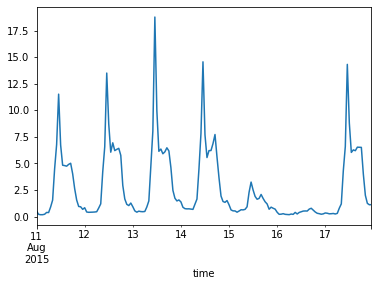

In [326]:
light_pred = (light_pred1 + light_pred2 + light_pred3 + light_pred4 + light_pred5) / 5
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"] = light_pred
data_light.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_light"].plot()

<h4>针对air构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

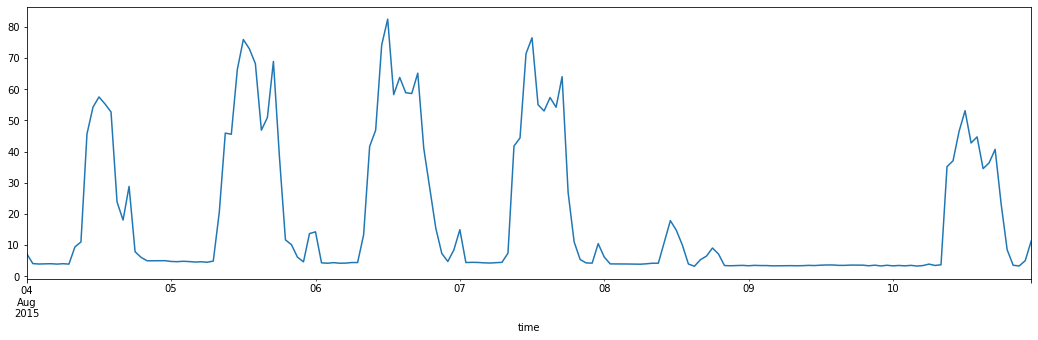

In [327]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_air"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [328]:
data_air = data.drop(columns=["value_socket", "value_light", "value_total"])
x_train_air = data_air.drop(columns=["value_air"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_air = data_air["value_air"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
x_test_air = data_air.drop(columns=["value_air"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_air.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [329]:
model_air1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred1 = model_air1.predict(x_test_air)

<h5>取最后7*24个点作为模型2预测值</h5>

In [330]:
air_pred2 = data_air.loc[: "2015-08-10 23:00:00", "value_air"].values[-7*24:]

<h5>构建catboost</h5>

In [331]:
model_air3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_air, y_train_air, sample_weight=sample_weight)
air_pred3 = model_air3.predict(x_test_air)

Learning rate set to 0.063357
0:	learn: 14.1010648	total: 3.12ms	remaining: 3.11s
1:	learn: 13.5535529	total: 6.07ms	remaining: 3.03s
2:	learn: 13.0645450	total: 9.02ms	remaining: 3s
3:	learn: 12.6199125	total: 12.1ms	remaining: 3s
4:	learn: 12.2041335	total: 14.9ms	remaining: 2.97s
5:	learn: 11.8093025	total: 17.7ms	remaining: 2.94s
6:	learn: 11.4531427	total: 20.6ms	remaining: 2.92s
7:	learn: 11.1296388	total: 23.3ms	remaining: 2.88s
8:	learn: 10.8390440	total: 26ms	remaining: 2.86s
9:	learn: 10.5690688	total: 28.7ms	remaining: 2.84s
10:	learn: 10.3217384	total: 31.4ms	remaining: 2.82s
11:	learn: 10.0827034	total: 34.1ms	remaining: 2.81s
12:	learn: 9.8755197	total: 36.8ms	remaining: 2.79s
13:	learn: 9.6743932	total: 39.5ms	remaining: 2.78s
14:	learn: 9.5037659	total: 42.3ms	remaining: 2.78s
15:	learn: 9.3488606	total: 45ms	remaining: 2.77s
16:	learn: 9.2005284	total: 47.9ms	remaining: 2.77s
17:	learn: 9.0570565	total: 50.8ms	remaining: 2.77s
18:	learn: 8.9303708	total: 53.5ms	remaini

219:	learn: 5.2149695	total: 540ms	remaining: 1.91s
220:	learn: 5.2091274	total: 542ms	remaining: 1.91s
221:	learn: 5.2039123	total: 545ms	remaining: 1.91s
222:	learn: 5.1980599	total: 547ms	remaining: 1.91s
223:	learn: 5.1894370	total: 549ms	remaining: 1.9s
224:	learn: 5.1842899	total: 552ms	remaining: 1.9s
225:	learn: 5.1805570	total: 554ms	remaining: 1.9s
226:	learn: 5.1765594	total: 556ms	remaining: 1.89s
227:	learn: 5.1695761	total: 559ms	remaining: 1.89s
228:	learn: 5.1624156	total: 561ms	remaining: 1.89s
229:	learn: 5.1571440	total: 564ms	remaining: 1.89s
230:	learn: 5.1517302	total: 566ms	remaining: 1.88s
231:	learn: 5.1457312	total: 568ms	remaining: 1.88s
232:	learn: 5.1390210	total: 571ms	remaining: 1.88s
233:	learn: 5.1270032	total: 573ms	remaining: 1.88s
234:	learn: 5.1208598	total: 576ms	remaining: 1.87s
235:	learn: 5.1147303	total: 578ms	remaining: 1.87s
236:	learn: 5.1093779	total: 581ms	remaining: 1.87s
237:	learn: 5.1044515	total: 583ms	remaining: 1.87s
238:	learn: 5.0

444:	learn: 4.2720168	total: 1.08s	remaining: 1.35s
445:	learn: 4.2704067	total: 1.08s	remaining: 1.35s
446:	learn: 4.2674581	total: 1.09s	remaining: 1.34s
447:	learn: 4.2653542	total: 1.09s	remaining: 1.34s
448:	learn: 4.2634610	total: 1.09s	remaining: 1.34s
449:	learn: 4.2622848	total: 1.09s	remaining: 1.34s
450:	learn: 4.2595921	total: 1.1s	remaining: 1.33s
451:	learn: 4.2559984	total: 1.1s	remaining: 1.33s
452:	learn: 4.2541739	total: 1.1s	remaining: 1.33s
453:	learn: 4.2533344	total: 1.1s	remaining: 1.33s
454:	learn: 4.2511032	total: 1.1s	remaining: 1.32s
455:	learn: 4.2484702	total: 1.11s	remaining: 1.32s
456:	learn: 4.2471466	total: 1.11s	remaining: 1.32s
457:	learn: 4.2450963	total: 1.11s	remaining: 1.32s
458:	learn: 4.2406571	total: 1.11s	remaining: 1.31s
459:	learn: 4.2364085	total: 1.12s	remaining: 1.31s
460:	learn: 4.2340514	total: 1.12s	remaining: 1.31s
461:	learn: 4.2317606	total: 1.12s	remaining: 1.31s
462:	learn: 4.2292427	total: 1.12s	remaining: 1.3s
463:	learn: 4.2276

670:	learn: 3.7710834	total: 1.62s	remaining: 795ms
671:	learn: 3.7698962	total: 1.62s	remaining: 793ms
672:	learn: 3.7690914	total: 1.63s	remaining: 790ms
673:	learn: 3.7679627	total: 1.63s	remaining: 788ms
674:	learn: 3.7673506	total: 1.63s	remaining: 785ms
675:	learn: 3.7657147	total: 1.63s	remaining: 783ms
676:	learn: 3.7647791	total: 1.64s	remaining: 780ms
677:	learn: 3.7632999	total: 1.64s	remaining: 778ms
678:	learn: 3.7618829	total: 1.64s	remaining: 776ms
679:	learn: 3.7603905	total: 1.64s	remaining: 773ms
680:	learn: 3.7594579	total: 1.65s	remaining: 771ms
681:	learn: 3.7571829	total: 1.65s	remaining: 768ms
682:	learn: 3.7555554	total: 1.65s	remaining: 766ms
683:	learn: 3.7529592	total: 1.65s	remaining: 763ms
684:	learn: 3.7513617	total: 1.65s	remaining: 761ms
685:	learn: 3.7469842	total: 1.66s	remaining: 759ms
686:	learn: 3.7440063	total: 1.66s	remaining: 756ms
687:	learn: 3.7412167	total: 1.66s	remaining: 754ms
688:	learn: 3.7382050	total: 1.66s	remaining: 751ms
689:	learn: 

895:	learn: 3.4360544	total: 2.16s	remaining: 251ms
896:	learn: 3.4350985	total: 2.17s	remaining: 249ms
897:	learn: 3.4337319	total: 2.17s	remaining: 246ms
898:	learn: 3.4330517	total: 2.17s	remaining: 244ms
899:	learn: 3.4328887	total: 2.17s	remaining: 241ms
900:	learn: 3.4316574	total: 2.17s	remaining: 239ms
901:	learn: 3.4308517	total: 2.18s	remaining: 237ms
902:	learn: 3.4295629	total: 2.18s	remaining: 234ms
903:	learn: 3.4276557	total: 2.18s	remaining: 232ms
904:	learn: 3.4271180	total: 2.18s	remaining: 229ms
905:	learn: 3.4255281	total: 2.19s	remaining: 227ms
906:	learn: 3.4228506	total: 2.19s	remaining: 224ms
907:	learn: 3.4219717	total: 2.19s	remaining: 222ms
908:	learn: 3.4214657	total: 2.19s	remaining: 220ms
909:	learn: 3.4202140	total: 2.2s	remaining: 217ms
910:	learn: 3.4190574	total: 2.2s	remaining: 215ms
911:	learn: 3.4168139	total: 2.2s	remaining: 212ms
912:	learn: 3.4162027	total: 2.2s	remaining: 210ms
913:	learn: 3.4151806	total: 2.21s	remaining: 208ms
914:	learn: 3.41

<h5>构建xgboost</h5>

In [332]:
model_air4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_air.loc[y_train_air > 0], y_train_air[y_train_air > 0])
air_pred4 = model_air4.predict(x_test_air)

<h5>构建深度模型</h5>

In [333]:
ds_air1 = timeseries_dataset_from_array(
    data=data_air.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air2 = timeseries_dataset_from_array(
    data=data_air.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air3 = timeseries_dataset_from_array(
    data=data_air.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_air = ds_air1.concatenate(ds_air2).concatenate(ds_air3).map(split_xy)
ds_air

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 46ms/step - loss: 445.9040 - mae: 13.3040
Epoch 2/100
124/124 [==============================] - 5s 40ms/step - loss: 317.0243 - mae: 11.9608
Epoch 3/100
124/124 [==============================] - 5s 40ms/step - loss: 259.5723 - mae: 10.5451
Epoch 4/100
124/124 [==============================] - 5s 40ms/step - loss: 178.6173 - mae: 8.5280
Epoch 5/100
124/124 [==============================] - 5s 41ms/step - loss: 128.3009 - mae: 7.1505
Epoch 6/100
124/124 [==============================] - 5s 42ms/step - loss: 109.4825 - mae: 6.5967
Epoch 7/100
124/124 [==============================] - 5s 41ms/step - loss: 96.2674 - mae: 6.2351
Epoch 8/100
124/124 [==============================] - 5s 41ms/step - loss: 89.1543 - mae: 5.9577
Epoch 9/100
124/124 [==============================] - 5s 41ms/step - loss: 86.0490 - mae: 5.8547
Epoch 10/100
124/124 [==============================] - 5s 41ms/step - loss: 76.6209 - mae: 5.5165
Epoch 11/1

124/124 [==============================] - 5s 41ms/step - loss: 8.1850 - mae: 1.7741
Epoch 84/100
124/124 [==============================] - 5s 41ms/step - loss: 8.2426 - mae: 1.7709
Epoch 85/100
124/124 [==============================] - 5s 41ms/step - loss: 7.2045 - mae: 1.6660
Epoch 86/100
124/124 [==============================] - 5s 41ms/step - loss: 6.9004 - mae: 1.6383
Epoch 87/100
124/124 [==============================] - 5s 41ms/step - loss: 7.1462 - mae: 1.6527
Epoch 88/100
124/124 [==============================] - 5s 41ms/step - loss: 6.8784 - mae: 1.6131
Epoch 89/100
124/124 [==============================] - 5s 42ms/step - loss: 7.3277 - mae: 1.6659
Epoch 90/100
124/124 [==============================] - 5s 41ms/step - loss: 7.0582 - mae: 1.6227
Epoch 91/100
124/124 [==============================] - 5s 42ms/step - loss: 6.5568 - mae: 1.5724
Epoch 92/100
124/124 [==============================] - 5s 41ms/step - loss: 5.9433 - mae: 1.5021
Epoch 93/100
124/124 [===========

2023-04-13 10:52:20,297 [INFO] saving LSTM model to ../models/LSTM_air.h5


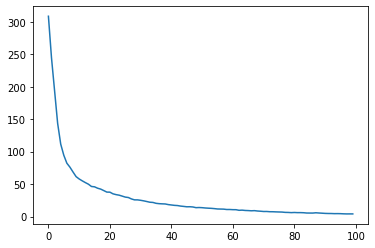

In [334]:
model_air5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_air.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_air5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_air5.load_weights("../models/LSTM_air.h5")
    logging.info("loading LSTM model from ../models/LSTM_air.h5")
except (OSError, ValueError) as e:
    history: History = model_air5.fit(
        ds_air,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_light5.save_weights("../models/LSTM_air.h5")
    logging.info("saving LSTM model to ../models/LSTM_air.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [335]:
air_pred5 = model_air5.predict(np.expand_dims(x_test_air.values, 0))[0, :, 0]

2023-04-13 10:52:21,001 [WARNING] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000002279A141598> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

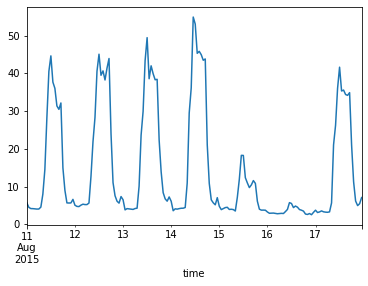

In [336]:
air_pred = (air_pred1 + air_pred2 + air_pred3 + air_pred4 + air_pred5) / 5
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"] = air_pred
data_air.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_air"].plot()

<h4>针对total构建模型</h4>

<h5>画图</h5>

<AxesSubplot:xlabel='time'>

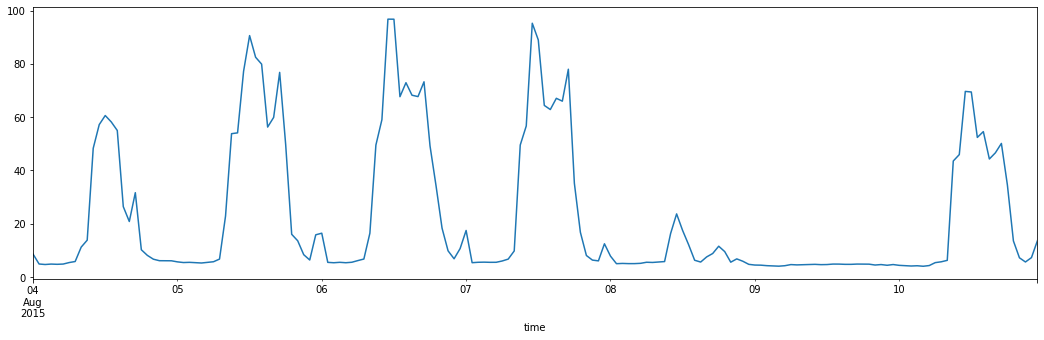

In [337]:
data.loc["2015-08-04 00:00:00" : "2015-08-10 23:00:00", "value_total"].plot(figsize=(18,5))

<h5>取出有用的数据</h5>

In [338]:
data_total = data.drop(columns=["value_socket", "value_light", "value_air"])
x_train_total = data_total.drop(columns=["value_total"]).loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = data_total["value_total"].loc[: "2015-08-10 23:00:00"].drop(index=DatetimeIndex(nan_index_hours))
y_train_total = y_train_total[y_train_total > 0]
x_train_total = x_train_total.loc[y_train_total.index]
x_test_total = data_total.drop(columns=["value_total"]).loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00"]

sample_weight = np.arange(0, x_train_total.shape[0], 1)
sample_weight = sample_weight / np.sum(sample_weight)

<h5>构建lightgbm</h5>

In [339]:
model_total1 = LGBMRegressor(n_estimators=1000, n_jobs=-1, random_state=42).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred1 = model_total1.predict(x_test_total)

<h5>取最后7*24个点作为模型2预测值</h5>

In [340]:
total_pred2 = data_total.loc[: "2015-08-10 23:00:00", "value_total"].values[-7*24:]

<h5>构建catboost</h5>

In [341]:
model_total3 = CatBoostRegressor(n_estimators=1000, random_state=1024).fit(x_train_total, y_train_total, sample_weight=sample_weight)
total_pred3 = model_total3.predict(x_test_total)

Learning rate set to 0.063357
0:	learn: 17.9276375	total: 3.63ms	remaining: 3.63s
1:	learn: 17.1601980	total: 6.84ms	remaining: 3.41s
2:	learn: 16.4567232	total: 9.91ms	remaining: 3.29s
3:	learn: 15.8084956	total: 12.9ms	remaining: 3.2s
4:	learn: 15.2151291	total: 15.8ms	remaining: 3.15s
5:	learn: 14.6656380	total: 18.8ms	remaining: 3.11s
6:	learn: 14.1577508	total: 21.7ms	remaining: 3.08s
7:	learn: 13.6980842	total: 24.7ms	remaining: 3.06s
8:	learn: 13.2673776	total: 27.6ms	remaining: 3.04s
9:	learn: 12.8845800	total: 30.6ms	remaining: 3.03s
10:	learn: 12.5227027	total: 33.4ms	remaining: 3.01s
11:	learn: 12.2018150	total: 36.3ms	remaining: 2.99s
12:	learn: 11.8992926	total: 39.1ms	remaining: 2.97s
13:	learn: 11.6292223	total: 42ms	remaining: 2.96s
14:	learn: 11.3720728	total: 44.7ms	remaining: 2.94s
15:	learn: 11.1417363	total: 47.6ms	remaining: 2.92s
16:	learn: 10.9274489	total: 50.5ms	remaining: 2.92s
17:	learn: 10.7265798	total: 53.3ms	remaining: 2.91s
18:	learn: 10.5606852	total: 

215:	learn: 5.9270677	total: 538ms	remaining: 1.95s
216:	learn: 5.9220757	total: 541ms	remaining: 1.95s
217:	learn: 5.9139432	total: 543ms	remaining: 1.95s
218:	learn: 5.9091452	total: 546ms	remaining: 1.95s
219:	learn: 5.9041645	total: 548ms	remaining: 1.94s
220:	learn: 5.8988425	total: 550ms	remaining: 1.94s
221:	learn: 5.8925553	total: 553ms	remaining: 1.94s
222:	learn: 5.8877148	total: 555ms	remaining: 1.93s
223:	learn: 5.8745521	total: 558ms	remaining: 1.93s
224:	learn: 5.8618515	total: 560ms	remaining: 1.93s
225:	learn: 5.8567669	total: 562ms	remaining: 1.93s
226:	learn: 5.8453912	total: 565ms	remaining: 1.92s
227:	learn: 5.8407270	total: 567ms	remaining: 1.92s
228:	learn: 5.8310206	total: 570ms	remaining: 1.92s
229:	learn: 5.8264362	total: 572ms	remaining: 1.92s
230:	learn: 5.8192363	total: 574ms	remaining: 1.91s
231:	learn: 5.8126035	total: 577ms	remaining: 1.91s
232:	learn: 5.8072337	total: 579ms	remaining: 1.91s
233:	learn: 5.8016721	total: 582ms	remaining: 1.9s
234:	learn: 5

437:	learn: 4.8746338	total: 1.08s	remaining: 1.38s
438:	learn: 4.8723624	total: 1.08s	remaining: 1.38s
439:	learn: 4.8690539	total: 1.08s	remaining: 1.38s
440:	learn: 4.8669289	total: 1.09s	remaining: 1.38s
441:	learn: 4.8638455	total: 1.09s	remaining: 1.37s
442:	learn: 4.8604789	total: 1.09s	remaining: 1.37s
443:	learn: 4.8573294	total: 1.09s	remaining: 1.37s
444:	learn: 4.8529906	total: 1.1s	remaining: 1.37s
445:	learn: 4.8498346	total: 1.1s	remaining: 1.36s
446:	learn: 4.8472907	total: 1.1s	remaining: 1.36s
447:	learn: 4.8440060	total: 1.1s	remaining: 1.36s
448:	learn: 4.8413878	total: 1.1s	remaining: 1.36s
449:	learn: 4.8381418	total: 1.11s	remaining: 1.35s
450:	learn: 4.8348511	total: 1.11s	remaining: 1.35s
451:	learn: 4.8325171	total: 1.11s	remaining: 1.35s
452:	learn: 4.8295447	total: 1.11s	remaining: 1.35s
453:	learn: 4.8261480	total: 1.12s	remaining: 1.34s
454:	learn: 4.8235675	total: 1.12s	remaining: 1.34s
455:	learn: 4.8213854	total: 1.12s	remaining: 1.34s
456:	learn: 4.818

660:	learn: 4.3086113	total: 1.62s	remaining: 832ms
661:	learn: 4.3047082	total: 1.63s	remaining: 830ms
662:	learn: 4.3027711	total: 1.63s	remaining: 828ms
663:	learn: 4.3017324	total: 1.63s	remaining: 825ms
664:	learn: 4.2988294	total: 1.63s	remaining: 823ms
665:	learn: 4.2972456	total: 1.64s	remaining: 820ms
666:	learn: 4.2962600	total: 1.64s	remaining: 818ms
667:	learn: 4.2930523	total: 1.64s	remaining: 815ms
668:	learn: 4.2920506	total: 1.64s	remaining: 813ms
669:	learn: 4.2882218	total: 1.64s	remaining: 810ms
670:	learn: 4.2874674	total: 1.65s	remaining: 808ms
671:	learn: 4.2856571	total: 1.65s	remaining: 805ms
672:	learn: 4.2820899	total: 1.65s	remaining: 803ms
673:	learn: 4.2805143	total: 1.65s	remaining: 800ms
674:	learn: 4.2787559	total: 1.66s	remaining: 798ms
675:	learn: 4.2765384	total: 1.66s	remaining: 795ms
676:	learn: 4.2742109	total: 1.66s	remaining: 793ms
677:	learn: 4.2710370	total: 1.66s	remaining: 790ms
678:	learn: 4.2700483	total: 1.67s	remaining: 788ms
679:	learn: 

882:	learn: 3.9274202	total: 2.16s	remaining: 287ms
883:	learn: 3.9261623	total: 2.17s	remaining: 284ms
884:	learn: 3.9257531	total: 2.17s	remaining: 282ms
885:	learn: 3.9250868	total: 2.17s	remaining: 279ms
886:	learn: 3.9237476	total: 2.17s	remaining: 277ms
887:	learn: 3.9217850	total: 2.18s	remaining: 274ms
888:	learn: 3.9203041	total: 2.18s	remaining: 272ms
889:	learn: 3.9196585	total: 2.18s	remaining: 270ms
890:	learn: 3.9167635	total: 2.18s	remaining: 267ms
891:	learn: 3.9149873	total: 2.19s	remaining: 265ms
892:	learn: 3.9137269	total: 2.19s	remaining: 262ms
893:	learn: 3.9127564	total: 2.19s	remaining: 260ms
894:	learn: 3.9116087	total: 2.19s	remaining: 257ms
895:	learn: 3.9103991	total: 2.19s	remaining: 255ms
896:	learn: 3.9080193	total: 2.2s	remaining: 252ms
897:	learn: 3.9065723	total: 2.2s	remaining: 250ms
898:	learn: 3.9052048	total: 2.2s	remaining: 248ms
899:	learn: 3.9012719	total: 2.21s	remaining: 245ms
900:	learn: 3.8998840	total: 2.21s	remaining: 243ms
901:	learn: 3.8

<h5>构建xgboost</h5>

In [342]:
model_total4 = XGBRegressor(n_estimators=1000, objective='reg:gamma', n_jobs=-1, random_state=1024).fit(x_train_total, y_train_total)
total_pred4 = model_total4.predict(x_test_total)
# TODO 改为objective='reg:linear'，并加入sample_weight

<h5>构建深度模型</h5>

In [343]:
ds_total1 = timeseries_dataset_from_array(
    data=data_total.loc[: "2014-03-14 12:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total2 = timeseries_dataset_from_array(
    data=data_total.loc["2014-04-23 21:00:00" : "2014-11-17 07:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total3 = timeseries_dataset_from_array(
    data=data_total.loc["2014-12-10 17:00:00" : "2015-08-10 23:00:00"].values,
    targets=None,
    sequence_length=7 * 24,
    sequence_stride=1,
    batch_size=128,
    shuffle=True,
    seed=42
)
ds_total = ds_total1.concatenate(ds_total2).concatenate(ds_total3).map(split_xy)
ds_total

<MapDataset shapes: ((None, None, 29), (None, None)), types: (tf.float64, tf.float64)>

Epoch 1/100
124/124 [==============================] - 8s 46ms/step - loss: 746.1407 - mae: 18.4310
Epoch 2/100
124/124 [==============================] - 5s 40ms/step - loss: 338.4595 - mae: 11.5787
Epoch 3/100
124/124 [==============================] - 5s 41ms/step - loss: 151.3749 - mae: 7.8779
Epoch 4/100
124/124 [==============================] - 5s 40ms/step - loss: 108.3855 - mae: 6.7306
Epoch 5/100
124/124 [==============================] - 5s 41ms/step - loss: 86.0350 - mae: 6.0700
Epoch 6/100
124/124 [==============================] - 5s 42ms/step - loss: 68.9364 - mae: 5.4524
Epoch 7/100
124/124 [==============================] - 5s 42ms/step - loss: 60.0030 - mae: 5.1105
Epoch 8/100
124/124 [==============================] - 5s 41ms/step - loss: 52.7165 - mae: 4.7827
Epoch 9/100
124/124 [==============================] - 5s 41ms/step - loss: 47.4203 - mae: 4.5575
Epoch 10/100
124/124 [==============================] - 5s 41ms/step - loss: 44.0068 - mae: 4.3909
Epoch 11/100


124/124 [==============================] - 5s 42ms/step - loss: 5.4855 - mae: 1.4209
Epoch 85/100
124/124 [==============================] - 5s 42ms/step - loss: 4.6331 - mae: 1.3072
Epoch 86/100
124/124 [==============================] - 5s 42ms/step - loss: 4.5306 - mae: 1.3001
Epoch 87/100
124/124 [==============================] - 5s 43ms/step - loss: 4.6755 - mae: 1.3209
Epoch 88/100
124/124 [==============================] - 5s 42ms/step - loss: 4.5465 - mae: 1.2876
Epoch 89/100
124/124 [==============================] - 5s 42ms/step - loss: 4.5700 - mae: 1.2962
Epoch 90/100
124/124 [==============================] - 5s 42ms/step - loss: 4.8023 - mae: 1.3271
Epoch 91/100
124/124 [==============================] - 5s 41ms/step - loss: 4.4058 - mae: 1.2695
Epoch 92/100
124/124 [==============================] - 5s 42ms/step - loss: 4.1259 - mae: 1.2270
Epoch 93/100
124/124 [==============================] - 5s 42ms/step - loss: 4.5812 - mae: 1.2980
Epoch 94/100
124/124 [===========

2023-04-13 11:01:13,593 [INFO] saving LSTM model to ../models/LSTM_total.h5


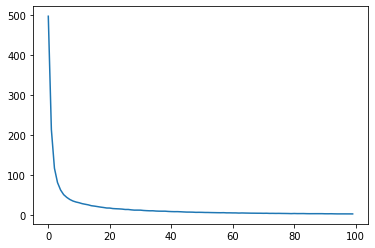

In [344]:
model_total5 = Sequential([
    BatchNormalization(axis=-1, input_shape=(None, x_train_total.shape[1])),
    LSTM(units=32, return_sequences=True, return_state=False),
    LSTM(units=64, return_sequences=True, return_state=False),
    LSTM(units=128, return_sequences=True, return_state=False),
    TimeDistributed(Dense(units=32, activation="relu")),
    TimeDistributed(Dense(units=16, activation="relu")),
    TimeDistributed(Dense(units=1, activation=None))
])
model_total5.compile(
    optimizer=Adam(),
    loss=MeanSquaredError(),
    metrics=["mae"]
)
try:
    model_total5.load_weights("../models/LSTM_total.h5")
    logging.info("loading LSTM model from ../models/LSTM_total.h5")
except (OSError, ValueError) as e:
    history: History = model_total5.fit(
        ds_total,
        batch_size=128,
        epochs=100,
        workers=12,
        use_multiprocessing=True,
        callbacks=[
            TensorBoard(log_dir="../logs/%s" % datetime.now().strftime("%Y-%m-%dT%H-%M"))
        ]
    )
    model_total5.save_weights("../models/LSTM_total.h5")
    logging.info("saving LSTM model to ../models/LSTM_total.h5")
    plt.figure()
    plt.plot(history.history["loss"])
    plt.show()

In [345]:
total_pred5 = model_total5.predict(np.expand_dims(x_test_total.values, 0))[0, :, 0]

2023-04-13 11:01:14,303 [WARNING] 11 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x00000227A3ED82F0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


<h5>模型融合</h5>

<AxesSubplot:xlabel='time'>

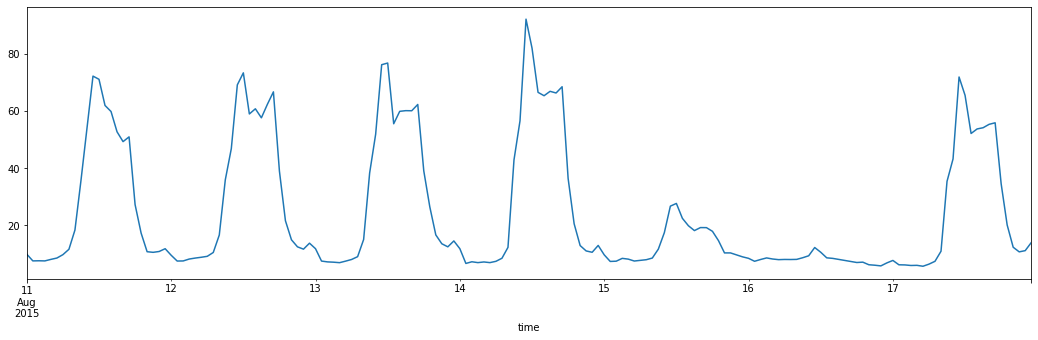

In [356]:
total_pred = (total_pred1 + total_pred2 + total_pred3 + total_pred4 + total_pred5) / 5
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"] = total_pred * 1.314
data_total.loc["2015-08-11 00:00:00" : "2015-08-17 23:00:00", "value_total"].plot(figsize=(18, 5))

<h3>预测未来七天的各项能耗，并输出用于评测的.csv文件：</h3>

In [357]:
results = DataFrame(index=pd.date_range(start="2015-08-11 00:00:00", end="2015-08-17 23:00:00", freq="1H"))
results['socket'] = clip_value(socket_pred, _min_val_=0)
results['light'] = clip_value(light_pred, _min_val_=0)
results['air'] = clip_value(air_pred, _min_val_=0)
results['total'] = clip_value(total_pred, _min_val_=0)
results = results[["total", "socket", "light", "air"]]
filename = "submit_%s.csv" % datetime.now().strftime("%Y-%m-%dT%H-%M")

results.to_csv(os.path.join("../data", filename), index=False)
results

,total,socket,light,air
2015-08-11 00:00:00,7.488453,0.825440,0.518041,5.707751
2015-08-11 01:00:00,5.713533,0.585055,0.208151,4.507954
2015-08-11 02:00:00,5.746013,0.556784,0.174232,4.185808
2015-08-11 03:00:00,5.711144,0.584745,0.176506,4.170547
2015-08-11 04:00:00,6.114836,0.586104,0.216413,4.106737
...,...,...,...,...
2015-08-17 19:00:00,15.286651,1.393869,3.984230,11.293587
2015-08-17 20:00:00,9.355623,1.160002,1.999930,6.186670
2015-08-17 21:00:00,8.121769,1.104813,1.244317,4.979236
2015-08-17 22:00:00,8.445956,1.070922,1.111709,5.478502


In [358]:
with ZipFile('../data/test.zip', 'w') as zip_file:
    zip_file.write(os.path.join("../data", filename), filename, compress_type=zipfile.ZIP_DEFLATED)